In [1]:
using Distributions
using Random
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(500, 300))

In [2]:
function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [3]:
using Distributions
using Roots

hodges_lehmann(X, Y) = median(x - y for x in X, y in Y)

winrate(X, Y) = mean((x < y) + (x == y)/2 for x in X, y in Y)

function brunner_munzel_test(X, Y; p=1/2, α=0.05)
    phat = winrate(X, Y)
    m, n = length(X), length(Y)
    sx2 = 1/(m-1) * sum(x -> (mean(y -> (y < x) + (y == x)/2, Y) - (1 - phat))^2, X)
    sy2 = 1/(n-1) * sum(y -> (mean(x -> (x < y) + (x == y)/2, X) - phat)^2, Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
    c = sehat > 0 ? cquantile(TDist(df), α/2) : 0.0
    confint_p = (phat - c*sehat, phat + c*sehat)
    (; p, phat, sehat, tvalue, df, pvalue, α, confint_p)
end

pvalue_brunner_munzel(X, Y; p=1/2) = brunner_munzel_test(X, Y; p).pvalue

function _pvalue_brunner_munzel(p, phat, sehat, df)
    tvalue = (phat - p)/sehat
    sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
end

function confint_bm_p_roots(X, Y; α=0.05)
    f(p) = brunner_munzel_test(X, Y; p).pvalue - α
    find_zeros(f, -1, 2)
end

function aminamax(X, Y)
    xmin, xmax = extrema(X)
    ymin, ymax = extrema(Y)
    width = max(xmax, ymax) - min(xmin, ymin)
    xmin - ymax - max(0.1, 0.05width), xmax - ymin + max(0.1, 0.05width)
end

function tieshift(X, Y; p=1/2)
    f(a) = winrate(X, Y .+ a) - p
    amin, amax = aminamax(X, Y)
    find_zero(f, (amin, amax))
end

function confint_bm_tieshift(X, Y; α=0.05)
    f(a) = brunner_munzel_test(X, Y .+ a).pvalue - α
    amin, amax = aminamax(X, Y)
    find_zeros(f, amin, amax)
end

confint_bm_tieshift (generic function with 1 method)

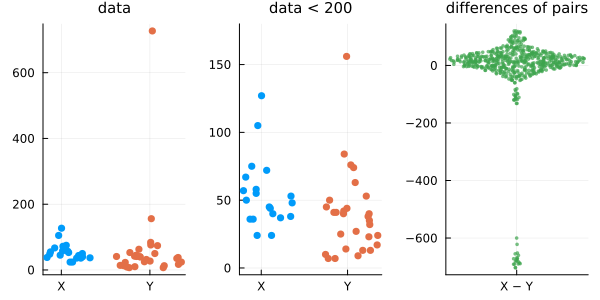

In [4]:
X = [24, 24, 36, 36, 37, 38, 40, 44, 45, 48, 50, 53, 55, 57, 58, 67, 72, 75, 105, 127]
Y = [7, 7, 9, 10, 13, 13, 14, 17, 23, 24, 25, 27, 32, 35, 38, 40, 40, 41, 41, 42, 44, 45, 50, 53, 63, 74, 76, 84, 156, 727]

P = dotplot([X, Y]; label="", xtick=(1:2, ["X", "Y"]), msc=:auto, title="data")
Q = dotplot([X, Y]; label="", xtick=(1:2, ["X", "Y"]), msc=:auto, title="data < 200", ylim=(-5, 180))
R = dotplot(vec(X .- Y'); xtick=(1:1, ["X − Y"]), label="", c=3, msc=:auto, ms=2, ma=0.7)
title!("differences of pairs")
plot(P, Q, R; layout=(1, 3), size=(600, 300))

Brunner-Munzel: null P-value = 0.0255,  point estimate = 14.5,  95% confidence interval = [2.0, 28.0]
Welch t-test: null P-value = 0.75,  point estimate = -7.78,  95% confidence interval = [-57.2, 41.6]


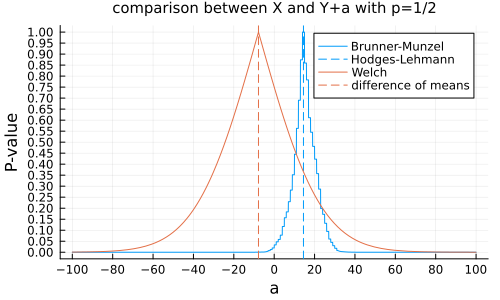

In [5]:
r(x) = round.(x; sigdigits=3)

P_BM = pvalue_brunner_munzel(X, Y)
HL = hodges_lehmann(X, Y)
CI_BM = confint_bm_tieshift(X, Y)
P_W = pvalue_welch(X, Y)
DM = mean(X) - mean(Y)
CI_W = confint_welch(X, Y)
println("Brunner-Munzel: ", "null P-value = ", r(P_BM), ",  point estimate = ", r(HL), ",  95% confidence interval = ", r.(CI_BM))
println("Welch t-test: ", "null P-value = ", r(P_W), ",  point estimate = ", r(DM), ",  95% confidence interval = ", r.(CI_W))

plot(a -> pvalue_brunner_munzel(X, Y .+ a), -100, 100; label="Brunner-Munzel", c=1)
vline!([HL]; label="Hodges-Lehmann", ls=:dash, c=1)
plot!(a -> pvalue_welch(X, Y .+ a); label="Welch", c=2)
vline!([DM]; label="difference of means", ls=:dash, c=2)
plot!(xtick=-100:20:100, ytick=0:0.05:1)
plot!(xguide="a", yguide="P-value")
title!("comparison between X and Y+a with p=1/2")

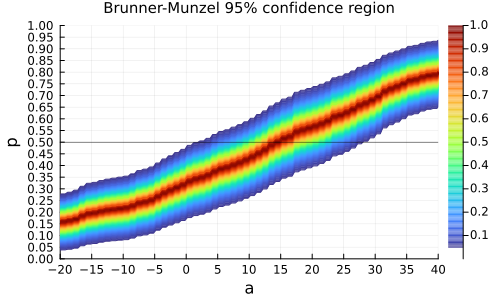

In [6]:
f(a, p) = pvalue_brunner_munzel(X, Y .+ a; p)
as = range(-20, 40, 301)
ps = range(0, 1, 201)
contour(as, ps, f; levels=0.05:0.005:1, c=:turbo)
hline!([0.5]; label="", c=:black, lw=0.5)
plot!(xtick=-50:5:50, ytick=0:0.05:1)
plot!(xguide="a", yguide="p")
title!("Brunner-Munzel 95% confidence region")

In [7]:
@show confint_bm_p_roots(X, Y .+ 30);

confint_bm_p_roots(X, Y .+ 30) = [0.5272780219907898, 0.8477219780092102]
